<h2 align="center">Decatur, Illinois Data Prep</h2> 

In this notebook, we will investigate the seismicity induced by subsurface CO$_2$ injection in Decature, Illinois. Let's begin by studying the spatial distribution of induced seismic events. At the centroid of the induced seismicity, we will evaluate time series of pressure and pressurization rate.

In [1]:
# Load relevant packages.
import utm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from orion_light.pressure_table import PressureTableModel
from orion_light.seismic_catalog import SeismicCatalog

In [2]:
# Conversion factor from 1 year to 1 second
t_scale = 60*60*24*365.25 

In [3]:
# Boolean flag to decide whether to write data to GCP.
write_to_GCP = False

### 1. Seismic Data 

In [4]:
# Read in seismic data.
seismic_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decaturSeismic.csv')

In [5]:
seismic_df.sample(10, random_state=440)

,b_value,b_value_epoch,depth,easting,epoch,event_id,latitude,longitude,magnitude,northing,source_radius,stress_drop
2543,1.324966,1.411376e+09,2035.763487,337694.879,1.376881e+09,3837.0,39.883824,-88.898150,-1.19,4416587.299,1.167327,0.1369
2937,1.112834,1.361686e+09,-1971.206949,338478.736,1.387301e+09,7081.0,39.884897,-88.889013,-1.69,4416689.748,0.749771,0.1080
1692,0.940971,1.388674e+09,2041.356294,338370.342,1.348342e+09,2570.0,39.884191,-88.890261,-0.07,4416613.653,1.481256,3.1462
2828,1.517922,1.451592e+09,1961.334959,338452.293,1.384465e+09,4217.0,39.884207,-88.889303,0.19,4416613.751,1.786041,5.3987
5236,0.933826,1.346742e+09,1917.976227,338656.029,1.489785e+09,6792.0,39.875504,-88.886682,-1.38,4415642.999,0.902164,0.1480
4920,0.926350,1.330554e+09,-2024.967998,338680.581,1.421883e+09,8061.0,39.873765,-88.886348,-1.67,4415449.375,1.481256,0.0210
1762,0.801082,1.410209e+09,2047.003962,337880.876,1.350179e+09,2673.0,39.879865,-88.895866,-0.18,4416143.639,1.990247,1.2694
4480,1.628604,1.358944e+09,-2110.268211,337743.185,1.410501e+09,7854.0,39.894523,-88.897880,-0.69,4417774.346,1.572691,0.2923
5252,1.186785,1.357402e+09,1911.664127,338565.077,1.496187e+09,6808.0,39.870801,-88.887617,-1.56,4415122.638,1.661079,0.0122
2987,1.196260,1.390092e+09,2056.278574,338489.131,1.388154e+09,4398.0,39.882460,-88.888825,-1.24,4416418.975,1.030174,0.1620


In [6]:
print('Do we have missing entries in our seismic data?') 
print(seismic_df.isnull().values.any())

Do we have missing entries in our seismic data?
False


In [7]:
# Reverse sign of depth if negative.
seismic_df.loc[seismic_df['depth']<0, 'depth'] *= -1
seismic_df.sample(10, random_state=440)

,b_value,b_value_epoch,depth,easting,epoch,event_id,latitude,longitude,magnitude,northing,source_radius,stress_drop
2543,1.324966,1.411376e+09,2035.763487,337694.879,1.376881e+09,3837.0,39.883824,-88.898150,-1.19,4416587.299,1.167327,0.1369
2937,1.112834,1.361686e+09,1971.206949,338478.736,1.387301e+09,7081.0,39.884897,-88.889013,-1.69,4416689.748,0.749771,0.1080
1692,0.940971,1.388674e+09,2041.356294,338370.342,1.348342e+09,2570.0,39.884191,-88.890261,-0.07,4416613.653,1.481256,3.1462
2828,1.517922,1.451592e+09,1961.334959,338452.293,1.384465e+09,4217.0,39.884207,-88.889303,0.19,4416613.751,1.786041,5.3987
5236,0.933826,1.346742e+09,1917.976227,338656.029,1.489785e+09,6792.0,39.875504,-88.886682,-1.38,4415642.999,0.902164,0.1480
4920,0.926350,1.330554e+09,2024.967998,338680.581,1.421883e+09,8061.0,39.873765,-88.886348,-1.67,4415449.375,1.481256,0.0210
1762,0.801082,1.410209e+09,2047.003962,337880.876,1.350179e+09,2673.0,39.879865,-88.895866,-0.18,4416143.639,1.990247,1.2694
4480,1.628604,1.358944e+09,2110.268211,337743.185,1.410501e+09,7854.0,39.894523,-88.897880,-0.69,4417774.346,1.572691,0.2923
5252,1.186785,1.357402e+09,1911.664127,338565.077,1.496187e+09,6808.0,39.870801,-88.887617,-1.56,4415122.638,1.661079,0.0122
2987,1.196260,1.390092e+09,2056.278574,338489.131,1.388154e+09,4398.0,39.882460,-88.888825,-1.24,4416418.975,1.030174,0.1620


We will now visualize the spatial distribution of the induced earthquakes with respect to their centroid.

In [8]:
# Compute centroid of induced seismicity as the arithmetic mean of coordinates of induced earthquakes. 
x_seismic_center = np.mean(seismic_df['easting'])
y_seismic_center = np.mean(seismic_df['northing'])
z_seismic_center = np.mean(seismic_df['depth'])

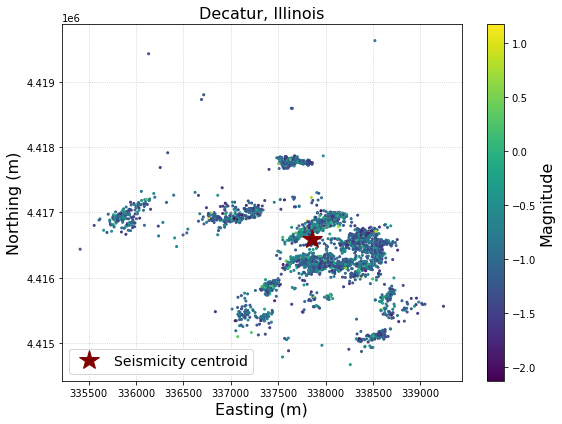

In [9]:
# Plot spatial distribution of induced earthquakes.
fig = plt.figure(figsize=(8,6))
plt.scatter(seismic_df['easting'], seismic_df['northing'], c=seismic_df['magnitude'], marker='o', s=4, cmap='viridis')
plt.plot(x_seismic_center, y_seismic_center, linestyle='None', marker='*', ms=20, color='maroon',
        label='Seismicity centroid')
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
h = plt.colorbar()
h.set_label('Magnitude', fontsize=16)
plt.legend(loc='best', prop={'size': 14})
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

Note that outliers pull our computed centroid away from the region of highest seismic event density. For a more accurate analysis, we will sub-divide our seismic data into 5 clusters using K-means clustering.

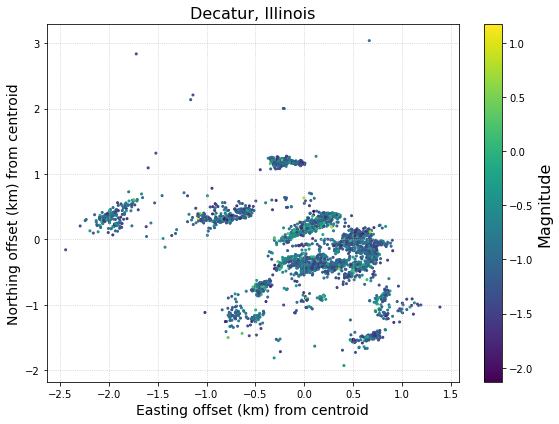

In [10]:
# Visualize above distribution relative to the coordinates of the computed centroid.
fig = plt.figure(figsize=(8,6))
plt.scatter((seismic_df['easting'] - x_seismic_center)*1e-3, 
            (seismic_df['northing'] - y_seismic_center)*1e-3, 
            c=seismic_df['magnitude'], marker='o', s=4, cmap='viridis')
plt.xlabel('Easting offset (km) from centroid', fontsize=14)
plt.ylabel('Northing offset (km) from centroid', fontsize=14)
h = plt.colorbar()
h.set_label('Magnitude', fontsize=16)
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

Clearly, the seismic data are confined to a box of size 4 km $\times$ 5 km. Let's confirm by computing the exact spans of the inducced seismicity in easting, northing, and depth.

In [11]:
x_seismic_span = (seismic_df['easting'].max() - seismic_df['easting'].min())*1e-3
y_seismic_span = (seismic_df['northing'].max() - seismic_df['northing'].min())*1e-3
print('Easting range or x-span of induced seismicity = %.2f km'% (x_seismic_span))
print('Northing range or y-span of induced seismicity = %.2f km'% (y_seismic_span))

Easting range or x-span of induced seismicity = 3.83 km
Northing range or y-span of induced seismicity = 4.97 km


In [12]:
z_seismic_span = (seismic_df['depth'].max() - seismic_df['depth'].min())
print('Depth range or z-span of induced seismicity = %.2f m'% (z_seismic_span))
print('Minimum depth of seismic events = %.2f m'% (seismic_df['depth'].min()))
print('Maximum depth of seismic events = %.2f m'% (seismic_df['depth'].max()))

Depth range or z-span of induced seismicity = 1266.83 m
Minimum depth of seismic events = 1169.88 m
Maximum depth of seismic events = 2436.71 m


In [13]:
t_seismic_span = (seismic_df['epoch'].max() - seismic_df['epoch'].min())/(60*60*24*365.25) # s -> years
print('Time span of seismic data = %.2f years'% (t_seismic_span))

Time span of seismic data = 7.10 years


In [14]:
# Prepare arrays for producing time series of cumulative earthquake counts.
t_vals_quakes = np.linspace(seismic_df['epoch'].min(), seismic_df['epoch'].max(), 100)
idx_quakes = np.digitize(seismic_df['epoch'], t_vals_quakes, right=False)

# Number of earthquakes per time bin
counts_per_bin = np.zeros(len(t_vals_quakes))
for n in range(1, len(t_vals_quakes)+1):
    counts_per_bin[n-1] = np.size(np.where(idx_quakes==n))
    
# Cumulative no. of earthquakes
cum_counts = np.cumsum(counts_per_bin)

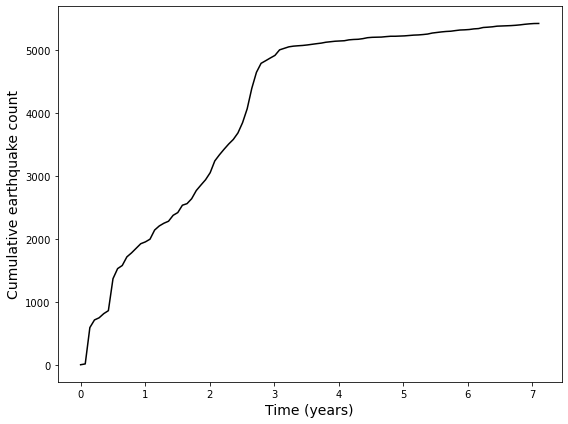

In [15]:
# Plot time series of cumulative earthquake counts.
fig = plt.figure(figsize=(8,6))
plt.plot((t_vals_quakes-t_vals_quakes[0])/t_scale, cum_counts, '-k')
plt.xlabel('Time (years)', fontsize=14)
plt.ylabel('Cumulative earthquake count', fontsize=14)
plt.tight_layout()
plt.show()

### 2. Split seismic data into clusters.

In [16]:
N_clusters = 6

# Create k-means object.
kmeans = KMeans(n_clusters=N_clusters)

# Fit to seismic data.
k_means_results = kmeans.fit_predict(seismic_df[['easting','northing']])

In [17]:
# Add cluster index to DataFrame.
seismic_df['cluster_idx'] = k_means_results

In [18]:
# Compute and store locations of seismicity centroids.
xs_centroids = np.zeros(N_clusters)
ys_centroids = np.zeros(N_clusters)
zs_centroids = np.zeros(N_clusters)

for n in range(N_clusters):
    cluster = seismic_df[seismic_df['cluster_idx']==n]
    xs_centroids[n] = np.mean(cluster['easting'])
    ys_centroids[n] = np.mean(cluster['northing'])
    zs_centroids[n] = np.mean(cluster['depth'])

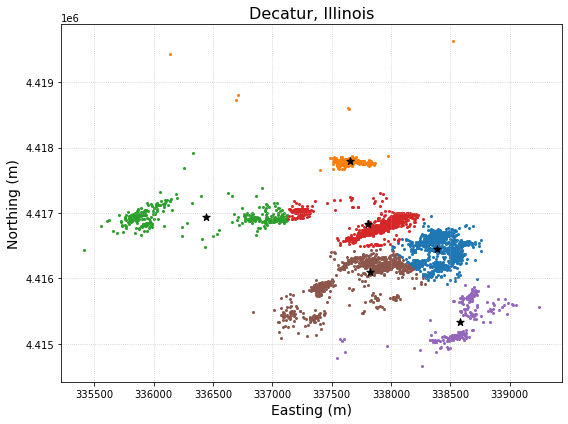

In [19]:
# Visualize spatial distribution of clusters.
fig = plt.figure(figsize=(8,6))
for n in range(N_clusters):
    cluster = seismic_df[seismic_df['cluster_idx']==n]
    plt.scatter(cluster['easting'], cluster['northing'], marker='o', s=4)
# Plot cluster centroids.
plt.scatter(x=xs_centroids, y=ys_centroids, marker='*', s=60, c='k')
plt.xlabel('Easting (m)', fontsize=14)
plt.ylabel('Northing (m)', fontsize=14)
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

In [20]:
# Write seismic catalogs for each cluster to GCP.
base_path = 'gs://us-geomechanicsforco2-dev-staging/temporal_datasets/decatur_illinois'

if write_to_GCP:
    for n in range(N_clusters):
        cluster = seismic_df[seismic_df['cluster_idx']==n]
        selection = cluster[['epoch', 'latitude', 'longitude', 'depth', 'easting', 'northing', 'magnitude']]
        selection.to_csv(base_path+'/loc%d'% (n+1)+'/seismic.csv',index=None)

In [21]:
# Write seismic catalogs for full data to GCP.
if write_to_GCP:
    selection = seismic_df[['epoch', 'latitude', 'longitude', 'depth', 'easting', 'northing', 'magnitude']]
    selection.to_csv(base_path+'/seismic.csv',index=None)

### 3. Injection Data

We have injection data for one well in Decatur, IL.

In [22]:
# Read in well location.
wells_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_well_location.csv')
print('No. of wells = %d'% (len(wells_df)))

No. of wells = 1


In [23]:
wells_df.head()

,well,longitude,latitude
0,IBDP1,-88.895039,39.877182


In [24]:
def calculate_utm_coordinates(lat, lon):
    """
    Convert catalog lat/lon coordinates to UTM
    """
    tmp = utm.from_latlon(lat, lon)
    easting = tmp[0]
    northing = tmp[1]
    utm_zone = str(tmp[2]) + tmp[3]
    return easting, northing, utm_zone

In [25]:
# Convert well location from lat/lon to UTM coordinates.
x_well, y_well, utm_well = calculate_utm_coordinates(wells_df.iloc[0]['latitude'], wells_df.iloc[0]['longitude'])
wells_df['easting'] = x_well
wells_df['northing'] = y_well
wells_df['utm_zone'] = utm_well
wells_df.head()

,well,longitude,latitude,easting,northing,utm_zone
0,IBDP1,-88.895039,39.877182,337945.286261,4.415844e+06,16S


In [26]:
# Read in injection data.
inj_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decaturInjection.csv')
inj_df.head()

,epoch,flow_rate
0,0.0,0.000000
1,86400.0,0.009925
2,172800.0,0.003243
3,259200.0,0.004338
4,345600.0,0.005837


### 4. Pressure Data

We have pressure data pre-computed over a grid of $(x,~y,~z,~t)$ values. The `PressureTableModel` class of `orion_light` numerically differentiates pressure to obtain `dp/dt`. We will then perform grid interpolation to compute values of pressure and `dp/dt` at the induced seismicity centroid.

**NOTE**: Our pressure data already incorporate in-situ spatial heterogeneity, and is therefore, superior to outputs from the radial flow model. Hence, for Decatur, we avoid computing pressures and `dp/dt` from injection flow rates using radial flow.

In [27]:
# Epochs
t_vals = np.ascontiguousarray(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/t.csv',
                   header=None).to_numpy(copy=True).squeeze())
print('No. of epochs of pressure measurements = %d' % (len(t_vals)))

No. of epochs of pressure measurements = 228


In [28]:
# x-grid values
x_vals = np.ascontiguousarray(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/x.csv',
                   header=None).to_numpy(copy=True).squeeze())
print('No. of x values = %d' % (len(x_vals)))

No. of x values = 64


In [29]:
# y-grid values
y_vals = np.ascontiguousarray(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/y.csv',
                   header=None).to_numpy(copy=True).squeeze())
print('No. of y values = %d' % (len(y_vals)))

No. of y values = 56


In [30]:
# z-grid values
z_vals = np.ascontiguousarray(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/z.csv',
                   header=None).to_numpy(copy=True).squeeze())
z_vals *= -1
z_vals = z_vals[::-1]
print('No. of z values = %d' % (len(z_vals)))

No. of z values = 17


In [31]:
# Pressure measurements
pressure = np.ascontiguousarray(pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/decatur_illinois/decatur_pressure_model_tough_flac_tables/pressure.csv',
                   header=None).to_numpy().squeeze())

In [32]:
pressure_nd = pressure.reshape((len(x_vals), len(y_vals), len(z_vals), len(t_vals)), order='f')
# Reverse z-axis.
pressure_nd = np.flip(pressure_nd, axis=2)
pressure = pressure_nd.flatten(order='f')
print('No. of pressure measurements = %d' % (len(pressure)))

No. of pressure measurements = 13891584


In [33]:
# Set up pressure table model.
flow_model = PressureTableModel()
data = {'t': t_vals,
        'x': x_vals,
        'y': y_vals,
        'z': z_vals,
        'pressure': pressure
       }

In [34]:
flow_model.load_array(**data)

In [35]:
print('Visualizing pressure profile at z = %.2f km and t = %.2f years'% (z_vals[0]*1e-3, t_vals[109]/t_scale))

Visualizing pressure profile at z = 2.15 km and t = 1.27 years


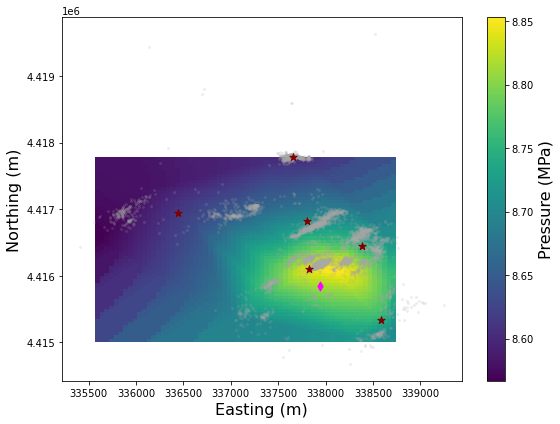

In [36]:
plot_p_orig = pressure_nd[:,:,0, 109].T

fig = plt.figure(figsize=(8,6))
im = plt.imshow(plot_p_orig*1e-6, aspect='auto', interpolation='nearest', origin='lower',
                extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
# Overplot seismic events.
plt.scatter(seismic_df['easting'],seismic_df['northing'], c='darkgray', marker='o', s=4, alpha=0.15)
# Show well location.
plt.scatter(wells_df['easting'], wells_df['northing'], c='magenta', marker='d', s=40)
# Plot cluster centroids.
plt.scatter(x=xs_centroids, y=ys_centroids, marker='*', s=60, c='maroon')
# Color bar of pressure plot
h = plt.colorbar(im)
h.set_label('Pressure (MPa)', fontsize=16)
# Axes labels
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
plt.tight_layout()
plt.show()

The magneta diamond marker in the above plot shows the lone injection well in the Decatur data. We indicate the centroid of induced seismicity by a maroon star marker.

### 5. Grid setup for computing spatiotemporal data products

In [37]:
# Time grid
t_grid = np.linspace(0, np.max(t_vals)/t_scale, 51) # years
print('We have %d time samples spanning %.2f years with a grid spacing of %.2f years.'
       % (len(t_grid), t_grid.max(), t_grid[1]-t_grid[0]))
t_grid *= t_scale # seconds

We have 51 time samples spanning 3.11 years with a grid spacing of 0.06 years.


Cluster 1
Along easting, we have 75 grid samples with a spacing of 0.01 km.
Along northing, we have 95 grid samples with a spacing of 0.01 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.14 km and t = 1.43 years


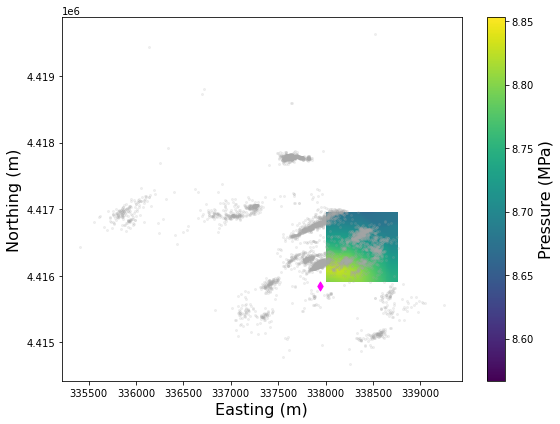

Cluster 2
Along easting, we have 75 grid samples with a spacing of 0.03 km.
Along northing, we have 95 grid samples with a spacing of 0.02 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.18 km and t = 1.43 years


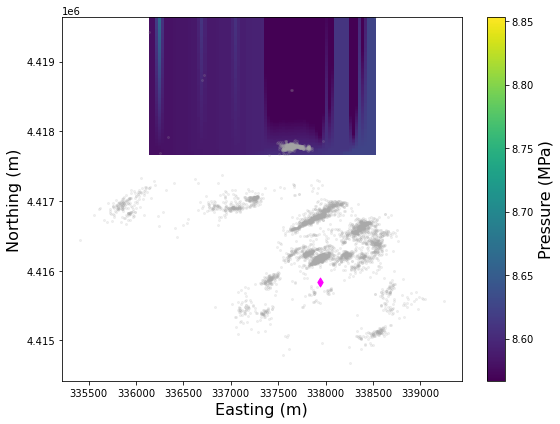

Cluster 3
Along easting, we have 75 grid samples with a spacing of 0.02 km.
Along northing, we have 95 grid samples with a spacing of 0.02 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.17 km and t = 1.43 years


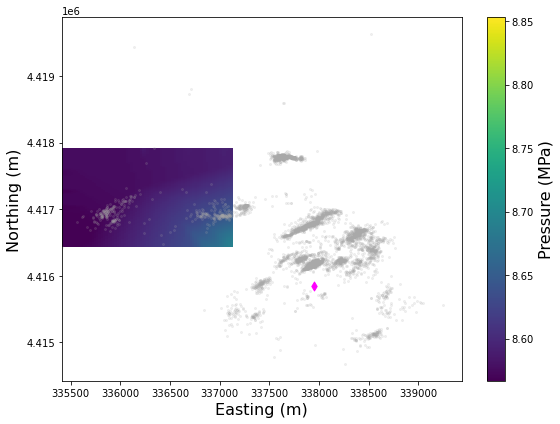

Cluster 4
Along easting, we have 75 grid samples with a spacing of 0.02 km.
Along northing, we have 95 grid samples with a spacing of 0.01 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.16 km and t = 1.43 years


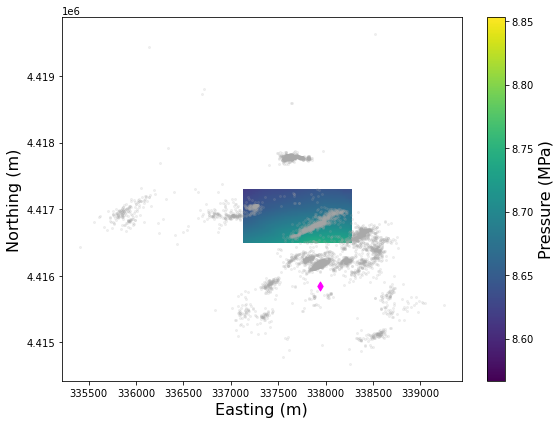

Cluster 5
Along easting, we have 75 grid samples with a spacing of 0.02 km.
Along northing, we have 95 grid samples with a spacing of 0.01 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.21 km and t = 1.43 years


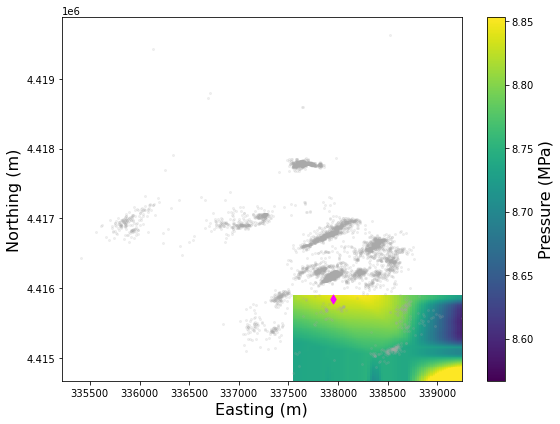

Cluster 6
Along easting, we have 75 grid samples with a spacing of 0.02 km.
Along northing, we have 95 grid samples with a spacing of 0.01 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.08 km and t = 1.43 years


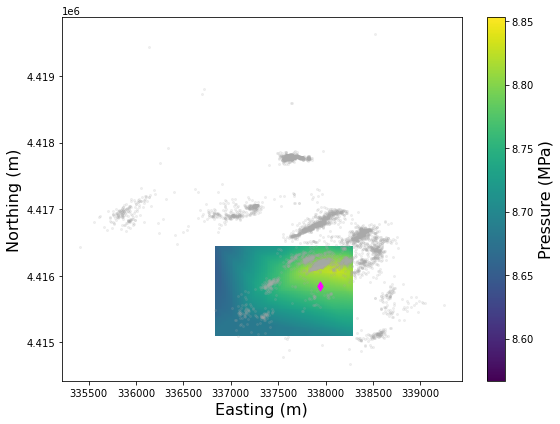

Using full seismic catalog
Along easting, we have 75 grid samples with a spacing of 0.05 km.
Along northing, we have 95 grid samples with a spacing of 0.05 km.
Grid shape (x, y, z, t) = 75 95 5 51


Plotting pressure profile at z = 2.12 km and t = 1.43 years


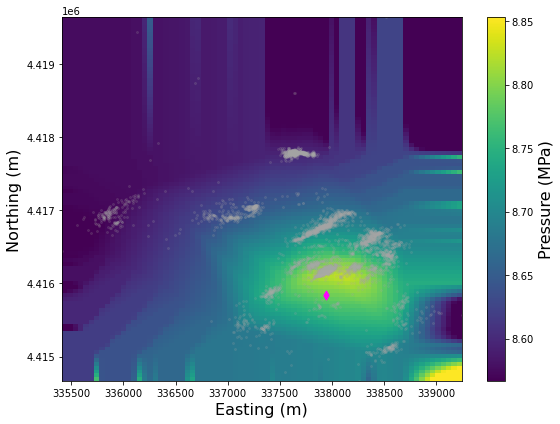

In [38]:
# Set up separate x-y-z grid for each cluster.
# Index N_clusters corresponds to the full seismic catalog.

for n in range(N_clusters+1):
    if n<N_clusters:
        cluster = seismic_df[seismic_df['cluster_idx']==n]
        print('Cluster %d'% (n+1))
    else:
        cluster = seismic_df
        print('Using full seismic catalog')
    
    x_grid = np.linspace(cluster['easting'].min(), cluster['easting'].max(), 75)
    print('Along easting, we have %d grid samples with a spacing of %.2f km.'
          % (len(x_grid), (x_grid[1]-x_grid[0])*1e-3))
    
    y_grid = np.linspace(cluster['northing'].min(), cluster['northing'].max(), 95)
    print('Along northing, we have %d grid samples with a spacing of %.2f km.' 
           % (len(y_grid), (y_grid[1]-y_grid[0])*1e-3))
    
    z_grid = np.linspace(cluster['depth'].min(), cluster['depth'].max(), 5)

    G = np.meshgrid(x_grid, y_grid, z_grid, t_grid, indexing='ij')
    print('Grid shape (x, y, z, t) =', len(x_grid), len(y_grid), len(z_grid), len(t_grid))
    
    # Evaluate pressure and dp/dt on grid.
    p = flow_model.p(*G)
    dpdt = flow_model.dpdt(*G)
    
    # TO DO: Write p and dp/dt to file for each cluster separately.
    print('\n')
    
    z_idx = np.argmin(np.abs(z_grid - z_vals[0]))
    t_idx = np.argmin(np.abs(t_grid - np.mean(t_vals)))
    
    plot_p = p[:,:, z_idx, t_idx].T.squeeze()
    print('Plotting pressure profile at z = %.2f km and t = %.2f years'% (z_grid[z_idx]*1e-3, t_grid[t_idx]/t_scale))
    fig = plt.figure(figsize=(8,6))
    im = plt.imshow(plot_p*1e-6, aspect='auto', interpolation='nearest', origin='lower',
                    extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
                    vmin=np.min(plot_p_orig)*1e-6, vmax=np.max(plot_p_orig)*1e-6)
    # Overplot seismic events.
    plt.scatter(seismic_df['easting'],seismic_df['northing'], c='darkgray', marker='o', s=4, alpha=0.15)
    # Show well location.
    plt.scatter(wells_df['easting'], wells_df['northing'], c='magenta', marker='d', s=40)
    # Color bar of pressure plot
    h = plt.colorbar(im)
    h.set_label('Pressure (MPa)', fontsize=16)
    # Axes labels
    plt.xlabel('Easting (m)', fontsize=16)
    plt.ylabel('Northing (m)', fontsize=16)
    plt.tight_layout()
    plt.show()

### 5. Evaluate pressure and `dp/dt` at the centroid of induced seismicity.

Cluster 1
Pressure and dp/dt computed.
Plotting time series of pressure


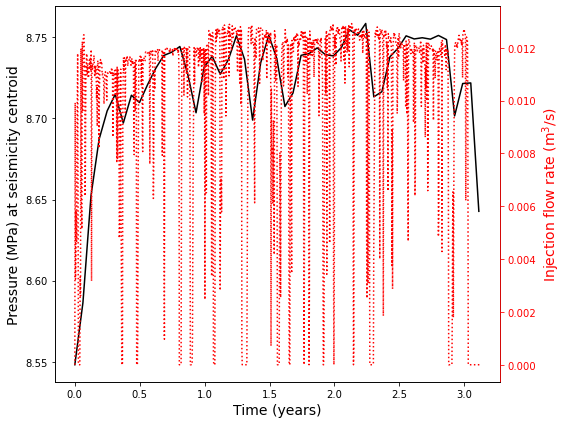

Plotting time series of dp/dt


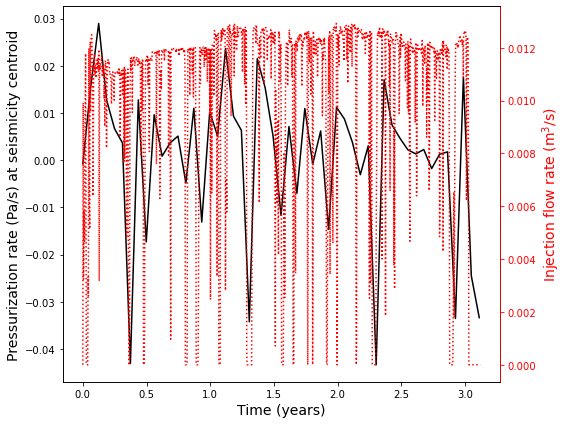

Cluster 2
Pressure and dp/dt computed.
Plotting time series of pressure


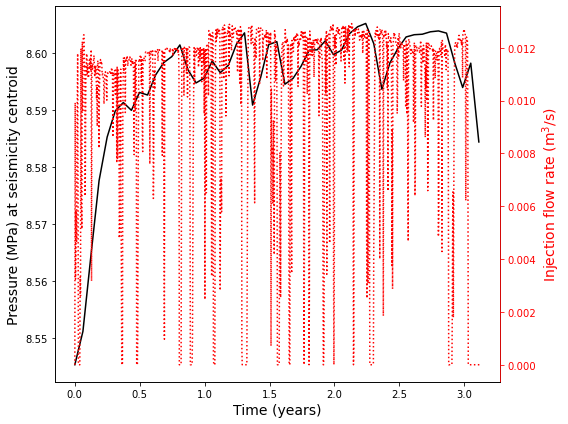

Plotting time series of dp/dt


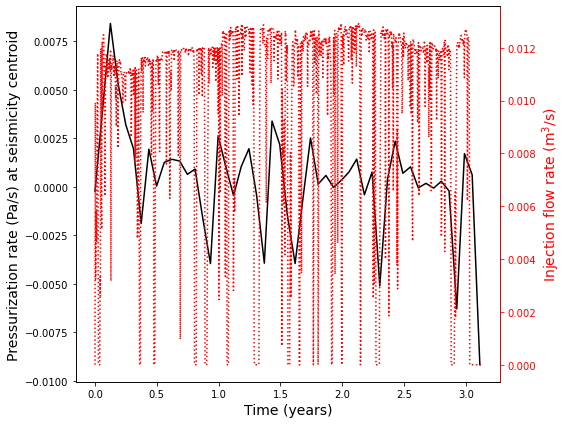

Cluster 3
Pressure and dp/dt computed.
Plotting time series of pressure


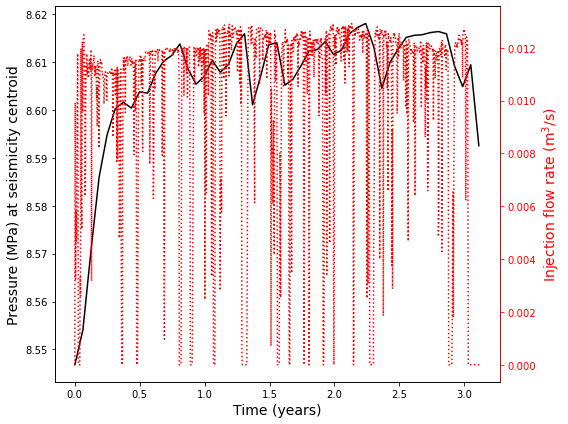

Plotting time series of dp/dt


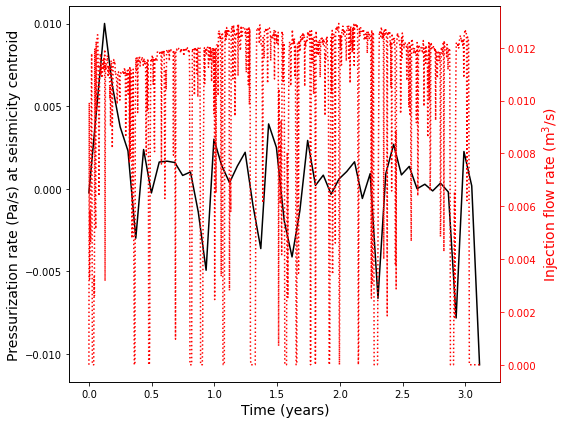

Cluster 4
Pressure and dp/dt computed.
Plotting time series of pressure


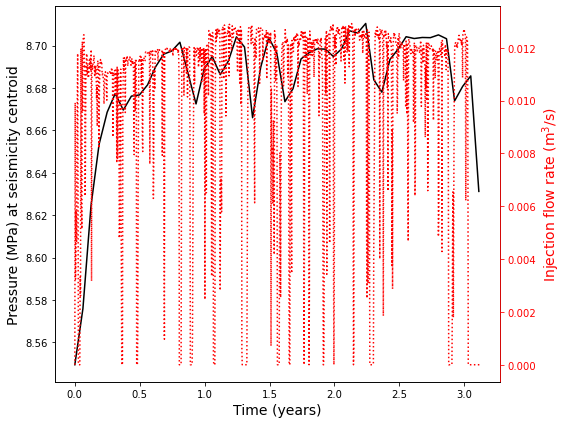

Plotting time series of dp/dt


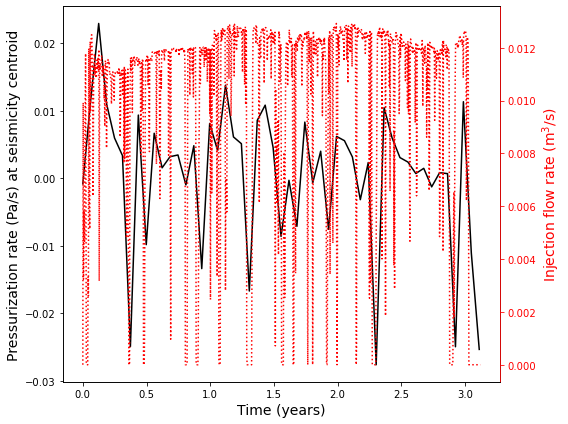

Cluster 5
Pressure and dp/dt computed.
Plotting time series of pressure


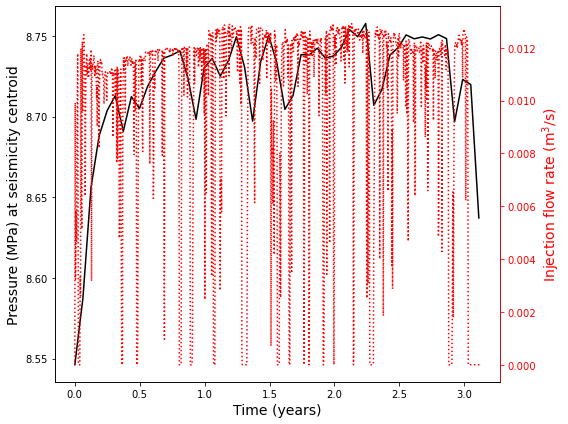

Plotting time series of dp/dt


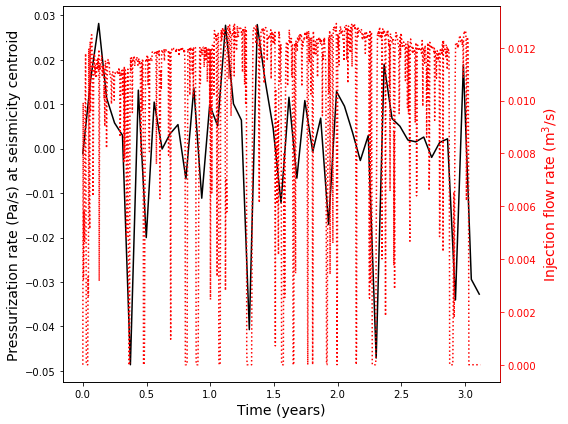

Cluster 6
Pressure and dp/dt computed.
Plotting time series of pressure


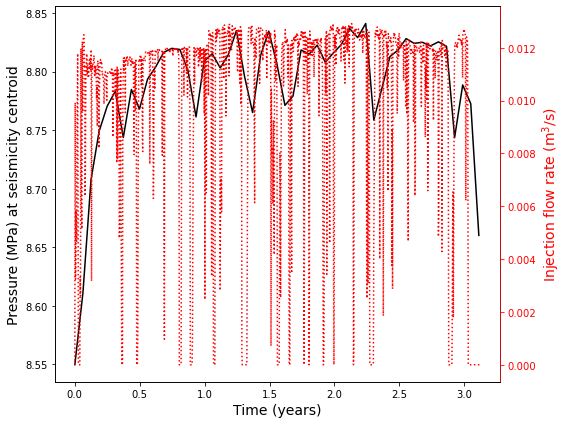

Plotting time series of dp/dt


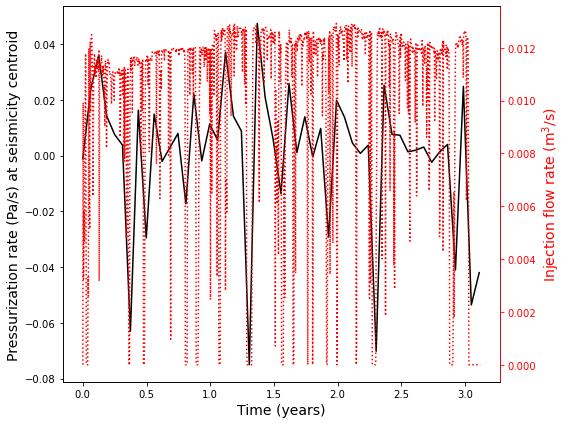

Using full seismic catalog
Pressure and dp/dt computed.
Plotting time series of pressure


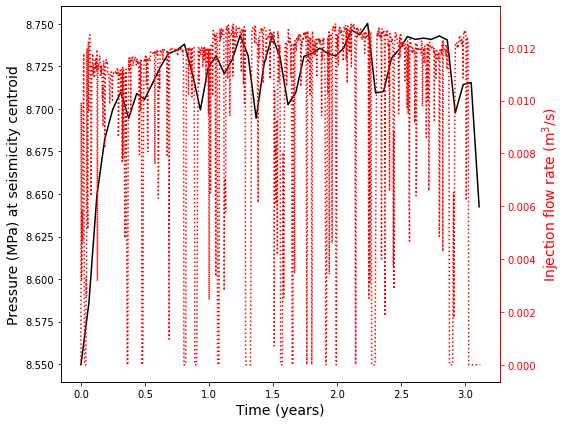

Plotting time series of dp/dt


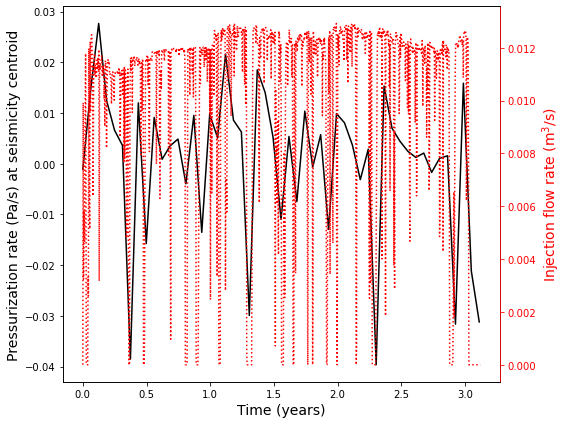

In [39]:
for n in range(N_clusters+1):
    if n < N_clusters:
        # Use cluster centroid
        print('Cluster %d'% (n+1))
        G_centroid = np.meshgrid(np.array([xs_centroids[n]]), np.array([ys_centroids[n]]),
                                 np.array([zs_centroids[n]]), t_grid, indexing='ij')
    else:
        # Use centroid computed from full seismic catalog.
        print('Using full seismic catalog')
        G_centroid = np.meshgrid(np.array([x_seismic_center]), np.array([y_seismic_center]),
                                 np.array([z_seismic_center]), t_grid, indexing='ij')
    
    # Evaluate pressure and dp/dt at seismicity centroid using flow model.
    p_centroid = flow_model.p(*G_centroid).squeeze()
    dpdt_centroid = flow_model.dpdt(*G_centroid).squeeze()
    print('Pressure and dp/dt computed.')
    
    data = {'epoch': t_grid, 'pressure': p_centroid, 'dpdt': dpdt_centroid}
    pressure_df = pd.DataFrame(data)
    
    # Write temporal data set to GCP.
    if write_to_GCP:
        if n < N_clusters:
            pressure_df.to_csv(base_path+'/loc%d'% (n+1)+'/pressure.csv',index=None)
        else:
            pressure_df.to_csv(base_path+'/pressure.csv',index=None)
        print('Write to GCP finished.')
    
    print('Plotting time series of pressure')
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(8,6))
    # Plot pressure time series at seismicity centroid.
    ax.plot(t_grid/t_scale, p_centroid*1e-6, '-k')
    ax.set_xlabel('Time (years)', fontsize=14)
    ax.set_ylabel('Pressure (MPa) at seismicity centroid', fontsize=14)
    # Plot injection data.
    ax2 = ax.twinx()
    ax2.plot(inj_df['epoch']/t_scale, inj_df['flow_rate'], ':r')
    ax2.set_ylabel(r'Injection flow rate (m$^3$/s)', fontsize=14, color='r')
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    plt.show()
    
    print('Plotting time series of dp/dt')
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(8,6))
    # Plot pressurization rate time series at seismicity centroid.
    ax.plot(t_grid/t_scale, dpdt_centroid, '-k')
    ax.set_xlabel('Time (years)', fontsize=14)
    ax.set_ylabel('Pressurization rate (Pa/s) at seismicity centroid', fontsize=14)
    # Plot injection data.
    ax2 = ax.twinx()
    ax2.plot(inj_df['epoch']/t_scale, inj_df['flow_rate'], ':r')
    ax2.set_ylabel(r'Injection flow rate (m$^3$/s)', fontsize=14)
    ax2.set_ylabel(r'Injection flow rate (m$^3$/s)', fontsize=14, color='r')
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    plt.show()